# Question 2: Peak times for crime occurrances

This notebook aims to answer the second question of the project.

In general:

- What are the peak times for crime occurences?

- Does it change according to season?

- Is there a concentration of crime around a specific period of the year?



## Initial setup

In [1]:
# Dependencies

from pathlib import Path 
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st


In [2]:
# plt.style.use('Solarize_Light2')
plt.style.use('bmh')

After loading the dependencies, we read in the data, select the columns we need for the analysis and rename them. We also make the year column a string and convert the columns of Month and Day of the Week into ordered categorical variables, so they keep their order when plotting.

In [3]:
# Read in data
df = pd.read_csv(Path('..', 'resources', 'mci_no_duplicates_2014_and_over.csv'))

# Keep only the relevant columns, rename them and drop na
df = (df[['OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOW', 'OCC_HOUR', 'MCI_CATEGORY', 'OFFENCE']]
    .rename(
        columns={
            'OCC_YEAR': 'Year',
            'OCC_MONTH': 'Month',
            'OCC_DAY': 'Day',
            'OCC_DOW': 'Weekday',
            'OCC_HOUR': 'Hour',
            'MCI_CATEGORY': 'Category',
            'OFFENCE': 'Offence',
        }
    )
)


# Make year a string 
df['Year'] = (df['Year']
    .astype('string')
    .str.replace('.0', '',regex=False)
)


# Make month an ordered categorical variable
df['Month'] = (df['Month']
    .astype(
        CategoricalDtype(
            categories=[
                'January',
                'February',
                'March',
                'April',
                'May',
                'June',
                'July',
                'August',
                'September',
                'October',
                'November',
                'December'
            ],
            ordered=True))
)

# Make day of the week an ordered categorical variable
df['Weekday'] = (df['Weekday']
    .str.strip()
    .astype(
        CategoricalDtype(
            categories=[
                'Monday',
                'Tuesday',
                'Wednesday',
                'Thursday',
                'Friday',
                'Saturday',
                'Sunday'
            ],
            ordered=True)
    )
)

df.head()

,Year,Month,Day,Weekday,Hour,Category,Offence
0,2014,January,1.0,Wednesday,3.0,Break and Enter,B&E
1,2014,January,1.0,Wednesday,4.0,Assault,Assault
2,2014,January,1.0,Wednesday,4.0,Theft Over,Theft Over
3,2014,January,1.0,Wednesday,4.0,Assault,Assault
4,2014,January,1.0,Wednesday,2.0,Assault,Assault Bodily Harm


## Calculate daily and hourly counts

We count the number of crime events in general and by category for each date, as well as for each hour. This will allow us to aggregate and visualize the data by month, day of the week and hour of the day.


In [4]:
# create a df with all dates and their weekday to join later
dates = df[['Year', 'Month', 'Day', 'Weekday']].drop_duplicates()
dates

,Year,Month,Day,Weekday
0,2014,January,1.0,Wednesday
84,2014,January,2.0,Thursday
136,2014,January,3.0,Friday
184,2014,January,4.0,Saturday
239,2014,January,5.0,Sunday
...,...,...,...,...
297925,2022,December,27.0,Tuesday
298025,2022,December,28.0,Wednesday
298130,2022,December,29.0,Thursday
298243,2022,December,30.0,Friday


In [5]:
# Get general daily counts
daily_count = (df
    .groupby(['Year', 'Month', 'Day'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Daily count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
daily_count.head()

,Year,Month,Day,Daily count,Weekday
0,2014,January,1.0,234,Wednesday
1,2014,January,2.0,53,Thursday
2,2014,January,3.0,64,Friday
3,2014,January,4.0,58,Saturday
4,2014,January,5.0,70,Sunday


In [6]:
# Get daily counts by category
daily_count_cat = (df
    .groupby(['Year', 'Month', 'Day', 'Category'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Daily count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
daily_count_cat.head()

,Year,Month,Day,Category,Daily count,Weekday
0,2014,January,1.0,Assault,183,Wednesday
1,2014,January,1.0,Auto Theft,3,Wednesday
2,2014,January,1.0,Break and Enter,24,Wednesday
3,2014,January,1.0,Robbery,6,Wednesday
4,2014,January,1.0,Theft Over,18,Wednesday


In [7]:
# Get general hourly counts
hour_count = (df
    .groupby(['Year', 'Month', 'Day', 'Hour'], as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Hourly count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
hour_count.head()

,Year,Month,Day,Hour,Hourly count,Weekday
0,2014,January,1.0,1.0,14,Wednesday
1,2014,January,1.0,2.0,16,Wednesday
2,2014,January,1.0,3.0,10,Wednesday
3,2014,January,1.0,4.0,7,Wednesday
4,2014,January,1.0,5.0,0,Wednesday


In [8]:
# Get hourly counts by category
hour_count_cat = (df
    .groupby(
        ['Year', 'Month', 'Day', 'Hour', 'Category'],
        as_index=False)
    .size()
    .fillna(0)
    .rename(columns={'size': 'Hourly count'})
    .merge(dates, how='left', on= ['Year', 'Month', 'Day'])
)
hour_count_cat.head()

,Year,Month,Day,Hour,Category,Hourly count,Weekday
0,2014,January,1.0,1.0,Assault,11,Wednesday
1,2014,January,1.0,1.0,Auto Theft,0,Wednesday
2,2014,January,1.0,1.0,Break and Enter,3,Wednesday
3,2014,January,1.0,1.0,Robbery,0,Wednesday
4,2014,January,1.0,1.0,Theft Over,0,Wednesday


## By month

In [9]:
# Get average daily counts by month
month_df = (daily_count
    .groupby('Month', as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
month_df

,Month,daily_average
0,January,84.526882
1,February,76.304659
2,March,85.265233
3,April,83.419355
4,May,91.415771
5,June,91.630824
6,July,94.849462
7,August,94.082437
8,September,92.745520
9,October,95.802867


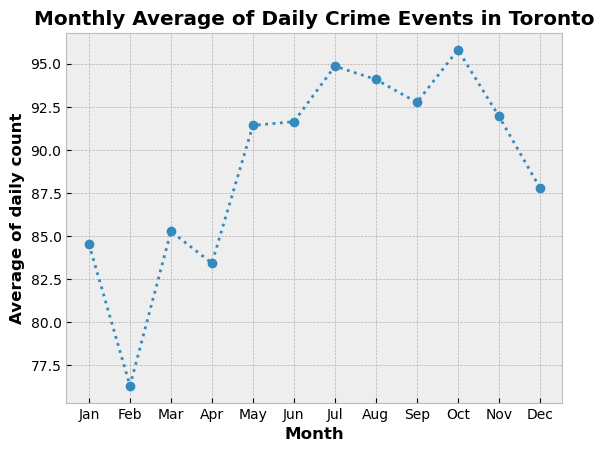

In [10]:

fig, ax = plt.subplots()
ax.plot(
    month_df['Month'],
    month_df['daily_average'],
    'o:'
)

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Monthly Average of Daily Crime Events in Toronto',
    fontdict={'weight': 700}
    )
plt.xticks(
    ticks=np.arange(12),
    labels=[m[0:3] for m in month_df['Month']]
)

plt.show()

In [11]:
# Get monthly average for each individual month/year
day_av_by_month = (daily_count
    .groupby(['Year', 'Month'], as_index=False)
    .agg(monthly_daily_average=('Daily count', 'mean'))
)
day_av_by_month

,Year,Month,monthly_daily_average
0,2014,January,77.741935
1,2014,February,67.935484
2,2014,March,75.161290
3,2014,April,77.129032
4,2014,May,87.548387
...,...,...,...
103,2022,August,103.612903
104,2022,September,105.645161
105,2022,October,108.516129
106,2022,November,105.645161


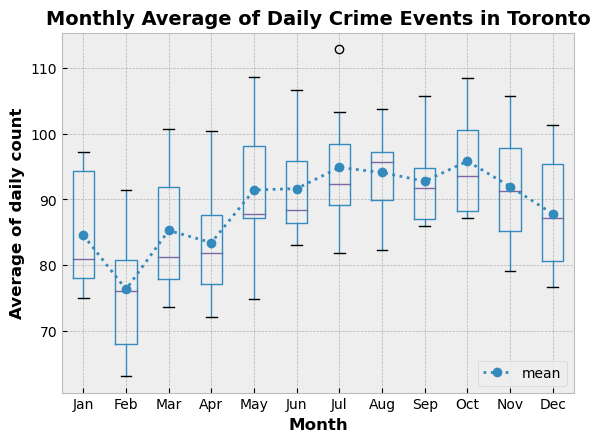

In [12]:
# Visualize monthly averages in a boxplot

fig, ax = plt.subplots()

day_av_by_month.boxplot(
    'monthly_daily_average',
    by='Month',
    positions=np.arange(12),
    ax=ax

)

ax.plot(
    month_df['Month'],
    month_df['daily_average'],
    'o:',
    label='mean',
    zorder=3
)

fig.suptitle('')

plt.legend(loc='lower right')

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Monthly Average of Daily Crime Events in Toronto',
    fontdict={'weight': 700, 'size': 14}
    )
# plt.xlabel('Month')
# plt.ylabel('Average of daily count')
# plt.title('Monthly Average of Daily Crime Events in Toronto')

plt.xticks(
    ticks=np.arange(12),
    labels=[m[0:3] for m in month_df['Month']]
)

plt.show()

In [13]:
jan = day_av_by_month.loc[day_av_by_month['Month']=='January']['monthly_daily_average']
feb = day_av_by_month.loc[day_av_by_month['Month']=='February']['monthly_daily_average']
mar = day_av_by_month.loc[day_av_by_month['Month']=='March']['monthly_daily_average']
apr = day_av_by_month.loc[day_av_by_month['Month']=='April']['monthly_daily_average']
may = day_av_by_month.loc[day_av_by_month['Month']=='May']['monthly_daily_average']
jun = day_av_by_month.loc[day_av_by_month['Month']=='June']['monthly_daily_average']
jul = day_av_by_month.loc[day_av_by_month['Month']=='July']['monthly_daily_average']
aug = day_av_by_month.loc[day_av_by_month['Month']=='August']['monthly_daily_average']
sep = day_av_by_month.loc[day_av_by_month['Month']=='September']['monthly_daily_average']
octb = day_av_by_month.loc[day_av_by_month['Month']=='October']['monthly_daily_average']
nov = day_av_by_month.loc[day_av_by_month['Month']=='November']['monthly_daily_average']
dec = day_av_by_month.loc[day_av_by_month['Month']=='December']['monthly_daily_average']

In [14]:
st.f_oneway(jan, feb, mar, apr, may, jun, jul, aug, sep, octb, nov, dec)

F_onewayResult(statistic=3.9573747172616023, pvalue=9.459993770771641e-05)

In [15]:
# https://stackoverflow.com/a/19960116
q1 = day_av_by_month.loc[day_av_by_month.Month.isin(['January', 'February', 'March'])]['monthly_daily_average']
q2 = day_av_by_month.loc[day_av_by_month.Month.isin(['April', 'May', 'June'])]['monthly_daily_average']
q3 = day_av_by_month.loc[day_av_by_month.Month.isin(['July', 'August', 'September'])]['monthly_daily_average']
q4 = day_av_by_month.loc[day_av_by_month.Month.isin(['October', 'November', 'December'])]['monthly_daily_average']

In [16]:
[x.mean() for x in [q1, q2, q3, q4]]

[82.03225806451613, 88.82198327359617, 93.89247311827957, 91.85065710872162]

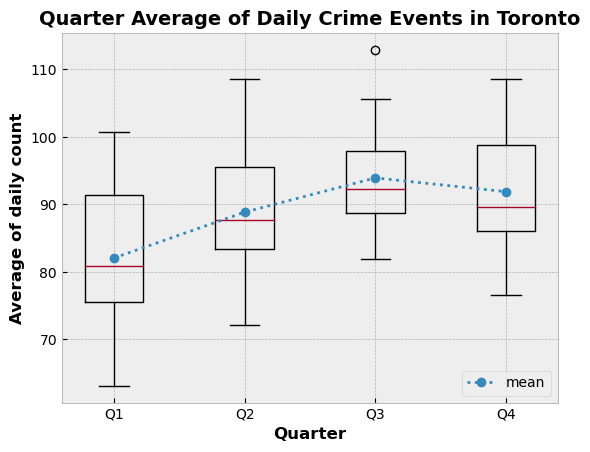

In [17]:
fig, ax = plt.subplots()


plt.boxplot(
    [q1, q2, q3, q4],
    labels=['Q1', 'Q2', 'Q3', 'Q4'],
    positions=np.arange(4)
)


ax.plot(
    ['Q1', 'Q2', 'Q3', 'Q4'],
    [x.mean() for x in [q1, q2, q3, q4]],
    'o:',
    label='mean',
    zorder=3
)

fig.suptitle('')

plt.legend(loc='lower right')

plt.xlabel('Quarter', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Quarter Average of Daily Crime Events in Toronto',
    fontdict={'weight': 700, 'size': 14}
    )


plt.show()


plt.show()

In [18]:
st.f_oneway(q1, q2, q3, q4)

F_onewayResult(statistic=8.894103147246307, pvalue=2.668144599861113e-05)

**Conclusion:** The month has an effect on the number of daily crime events in Toronto. Crimes are lower during the first quarter of the year (i.e. winter), while the highest daily counts are during the third quarter of the year (i.e. summer).

In [19]:
month_cat_df = (daily_count_cat
    .groupby(['Month', 'Category'], as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
month_cat_df.head()

,Month,Category,daily_average
0,January,Assault,43.831541
1,January,Auto Theft,10.845878
2,January,Break and Enter,18.946237
3,January,Robbery,8.043011
4,January,Theft Over,2.860215


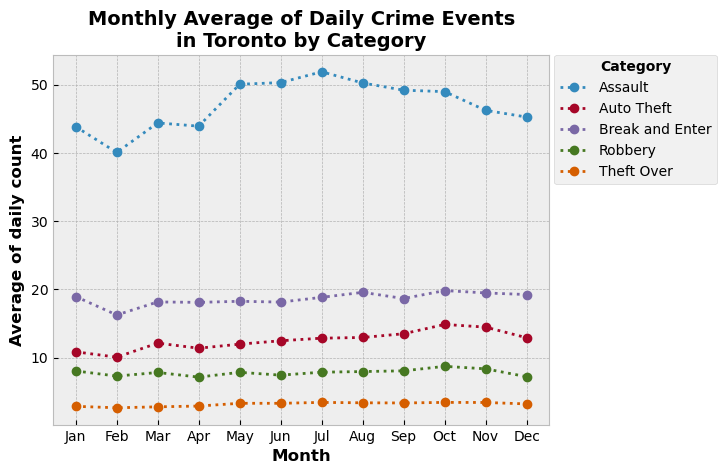

In [20]:
# Visualize

fig, ax = plt.subplots()

cats = list(month_cat_df['Category'].unique())

for cat in cats:
    this_data = month_cat_df.loc[month_cat_df ['Category'] == cat]
    # add this category to plot
    ax.plot(
        this_data['Month'],
        this_data['daily_average'],
        'o:',
        label=cat
    )

plt.xlabel('Month', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Monthly Average of Daily Crime Events\nin Toronto by Category',
    fontdict={'weight': 700, 'size': 14}
    )

# plt.xlabel('Month')
# plt.ylabel('Average of daily count')
# plt.title('Monthly Average of Daily Crime Events\nin Toronto by Category')

plt.xticks(
    ticks=np.arange(12),
    labels=[m[0:3] for m in month_df['Month']]
)
plt.legend(loc=(1.01, 0.65), title='Category', title_fontproperties={'weight': 700})

plt.show()

## By Day of the Week

In [21]:
dow_df = (daily_count
    .groupby('Weekday', as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
dow_df

,Weekday,daily_average
0,Monday,88.880597
1,Tuesday,87.618337
2,Wednesday,89.627660
3,Thursday,89.910638
4,Friday,96.031915
5,Saturday,93.408511
6,Sunday,90.136461


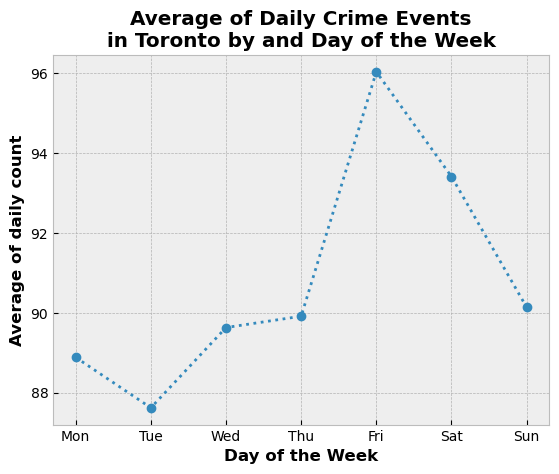

In [22]:

fig, ax = plt.subplots()

ax.plot(
    dow_df['Weekday'],
    dow_df['daily_average'],
    'o:'
)

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Average of Daily Crime Events\nin Toronto by and Day of the Week',
    fontdict={'weight': 700}
    )

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in dow_df['Weekday']]
)

plt.show()

In [23]:
day_av_by_dow = (daily_count
    .groupby(['Year', 'Month', 'Weekday'], as_index=False)
    .agg(dow_daily_average=('Daily count', 'mean'))
)
day_av_by_dow

,Year,Month,Weekday,dow_daily_average
0,2014,January,Monday,65.00
1,2014,January,Tuesday,75.75
2,2014,January,Wednesday,105.60
3,2014,January,Thursday,70.00
4,2014,January,Friday,81.80
...,...,...,...,...
751,2022,December,Wednesday,94.00
752,2022,December,Thursday,108.60
753,2022,December,Friday,101.60
754,2022,December,Saturday,103.40


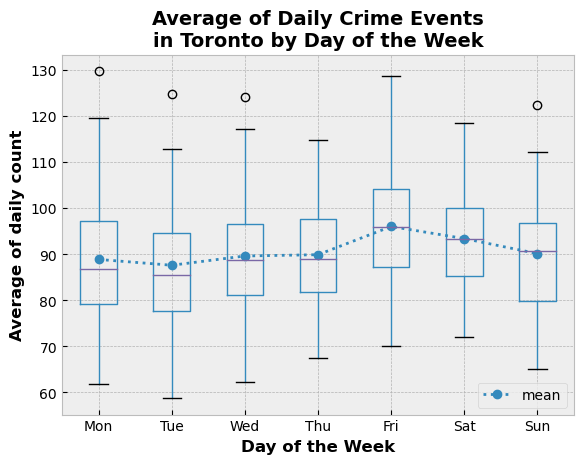

In [24]:
fig, ax = plt.subplots()


day_av_by_dow.boxplot(
    'dow_daily_average',
    by='Weekday',
    positions=np.arange(7),
    ax=ax

)

ax.plot(
    dow_df['Weekday'],
    dow_df['daily_average'],
    'o:',
    label='mean'
)

fig.suptitle('')

plt.legend(loc='lower right')

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Average of daily count', fontdict={'weight': 700})
plt.title(
    'Average of Daily Crime Events\nin Toronto by Day of the Week',
    fontdict={'weight': 700, 'size': 14}
    )


# plt.xlabel('Day of the Week')
# plt.ylabel('Average of daily count')
# plt.title('Average of Daily Crime Events\nin Toronto by Day of the Week')

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in dow_df['Weekday']]
)


plt.show()

In [25]:
mon = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Monday']['dow_daily_average']
tue = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Tuesday']['dow_daily_average']
wed = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Wednesday']['dow_daily_average']
thu = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Thursday']['dow_daily_average']
fri = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Friday']['dow_daily_average']
sat = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Saturday']['dow_daily_average']
sun = day_av_by_dow.loc[day_av_by_dow['Weekday'] == 'Sunday']['dow_daily_average']

In [26]:
st.f_oneway(mon, tue, wed, thu, fri, sat, sun)

F_onewayResult(statistic=6.780278991460453, pvalue=5.168951176091798e-07)

In [27]:
dow_cat_df = (daily_count_cat
    .groupby(['Weekday', 'Category'], as_index=False)
    .agg(daily_average=('Daily count', 'mean'))
)
dow_cat_df.head()

,Weekday,Category,daily_average
0,Monday,Assault,45.724947
1,Monday,Auto Theft,12.722814
2,Monday,Break and Enter,19.255864
3,Monday,Robbery,7.833689
4,Monday,Theft Over,3.343284


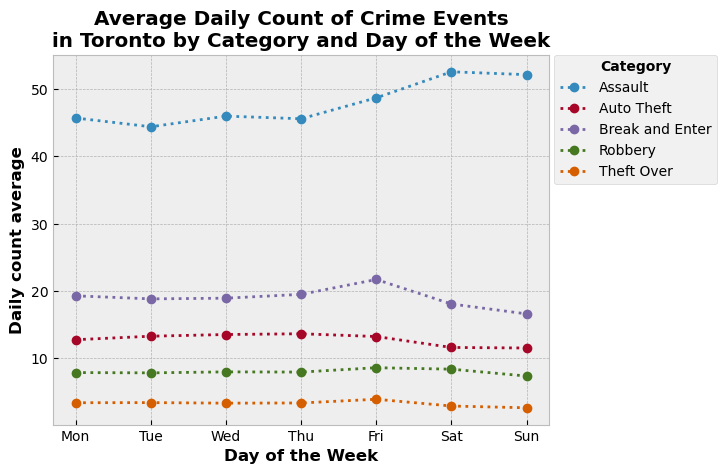

In [28]:
# Visualize

fig, ax = plt.subplots()

for cat in cats:
    this_data = dow_cat_df.loc[dow_cat_df['Category'] == cat]
    # add this category to plot
    ax.plot(
        this_data['Weekday'],
        this_data['daily_average'],
        'o:',
        label=cat
    )

plt.xlabel('Day of the Week', fontdict={'weight': 700})
plt.ylabel('Daily count average', fontdict={'weight': 700})
plt.title(
    'Average Daily Count of Crime Events\nin Toronto by Category and Day of the Week',
    fontdict={'weight': 700}
)

plt.xticks(
    ticks=np.arange(7),
    labels=[m[0:3] for m in dow_df['Weekday']]
)
plt.legend(loc=(1.01, 0.65), title='Category', title_fontproperties={'weight': 700})

plt.show()

## By Hour of Day

In [29]:
hour_df = (hour_count
    .groupby('Hour', as_index=False)
    .agg(hour_average=('Hourly count', 'mean'))
)
hour_df

,Hour,hour_average
0,1.0,3.636499
1,2.0,3.553465
2,3.0,2.955197
3,4.0,2.356033
4,5.0,1.844683
5,6.0,1.617682
6,7.0,1.879630
7,8.0,2.569594
8,9.0,2.970430
9,10.0,3.038829


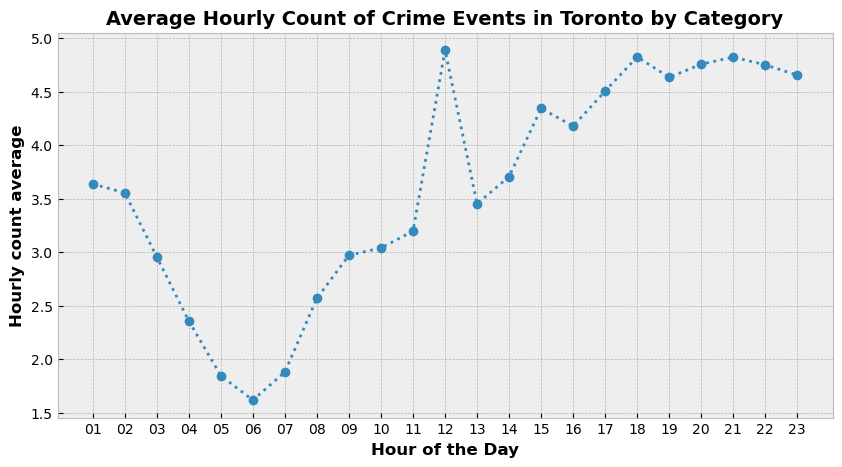

In [30]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(
    hour_df['Hour'],
    hour_df['hour_average'],
    'o:'
)

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Hourly count average', fontdict={'weight': 700})
plt.title(
    'Average Hourly Count of Crime Events in Toronto by Category',
    fontdict={'weight': 700, 'size': 14}
    )

# plt.xlabel('Hour of the Day')
# plt.ylabel('Average of hourly count')
# plt.title('Average Hourly Crime Events in Toronto')

plt.xticks(
    ticks=np.arange(1, 24),
    labels=[str(n).zfill(2) for n in np.arange(1, 24)]
)

plt.show()

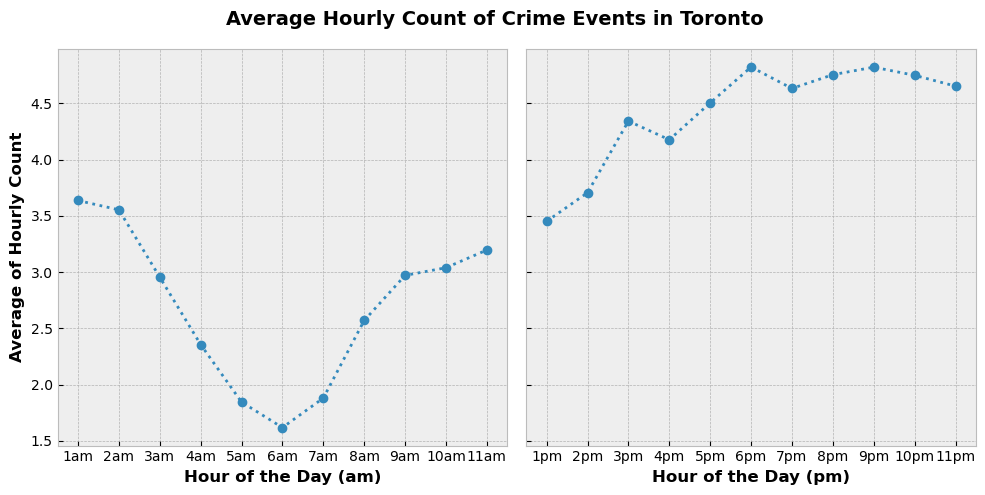

In [63]:
hour_before12_df = hour_df.loc[hour_df['Hour']<12]
hour_after12_df = hour_df.loc[hour_df['Hour']>12]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), sharey=True)

for ax in [ax1, ax2]:
    if ax is ax1:
        the_df = hour_before12_df
        # hour_labels = [str(n).zfill(2) for n in np.arange(1, 12)]
        ampm = 'am'
        hour_ticks = np.arange(1, 12)
        ax.set_ylabel('Average of Hourly Count', fontdict={'weight': 700})
    else:
        the_df = hour_after12_df
        ampm = 'pm'
        hour_ticks = np.arange(13, 24)
        # hour_labels = [str(n) for n in np.arange(13, 24)]


    ax.plot(
        the_df['Hour'],
        the_df['hour_average'],
        'o:'
    )


    ax.set_xlabel('Hour of the Day (' + ampm + ')', fontdict={'weight': 700})

    hour_labels = [str(n) + ampm for n in np.arange(1, 12)]
    ax.set_xticks(
        ticks=hour_ticks,
        labels=hour_labels
    )

fig.suptitle(
    'Average Hourly Count of Crime Events in Toronto',
    fontweight=700, fontsize=14
)

fig.tight_layout()

plt.show()

In [49]:
hour_cat_df = (hour_count_cat
    .groupby(['Hour', 'Category'], as_index=False)
    .agg(hour_average=('Hourly count', 'mean'))
)
hour_cat_df.head()

,Hour,Category,hour_average
0,1.0,Assault,1.908303
1,1.0,Auto Theft,0.435783
2,1.0,Break and Enter,0.836320
3,1.0,Robbery,0.383811
4,1.0,Theft Over,0.072282


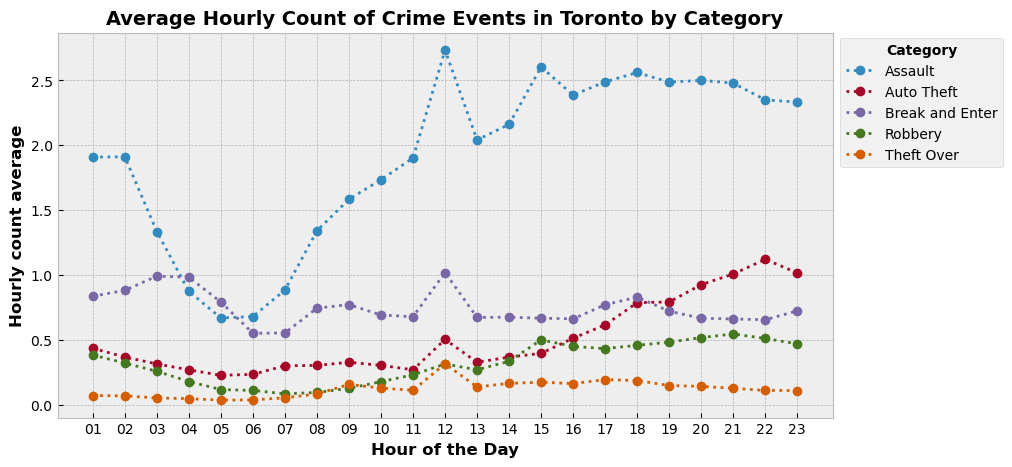

In [50]:
# Visualize

fig, ax = plt.subplots(figsize=(10, 5))

for cat in cats:
    this_data = hour_cat_df.loc[hour_cat_df['Category'] == cat]
    # add this category to the plot
    ax.plot(
        this_data['Hour'],
        this_data['hour_average'],
        'o:',
        label=cat
    )

plt.xlabel('Hour of the Day', fontdict={'weight': 700})
plt.ylabel('Hourly count average', fontdict={'weight': 700})
plt.title(
    'Average Hourly Count of Crime Events in Toronto by Category',
    fontdict={'weight': 700, 'size': 14}
    )

# plt.xlabel('Hour of the Day')
# plt.ylabel('Average of hourly count')
# plt.title('Average Hourly Crime Events in Toronto by Category')

plt.xticks(
    ticks=np.arange(1,24),
    labels=[str(n).zfill(2) for n in np.arange(1,24)]
)
plt.legend(loc=(1.01, 0.65), title='Category', title_fontproperties={'weight': 700})
plt.grid(True, which='both', axis='x')


plt.show()

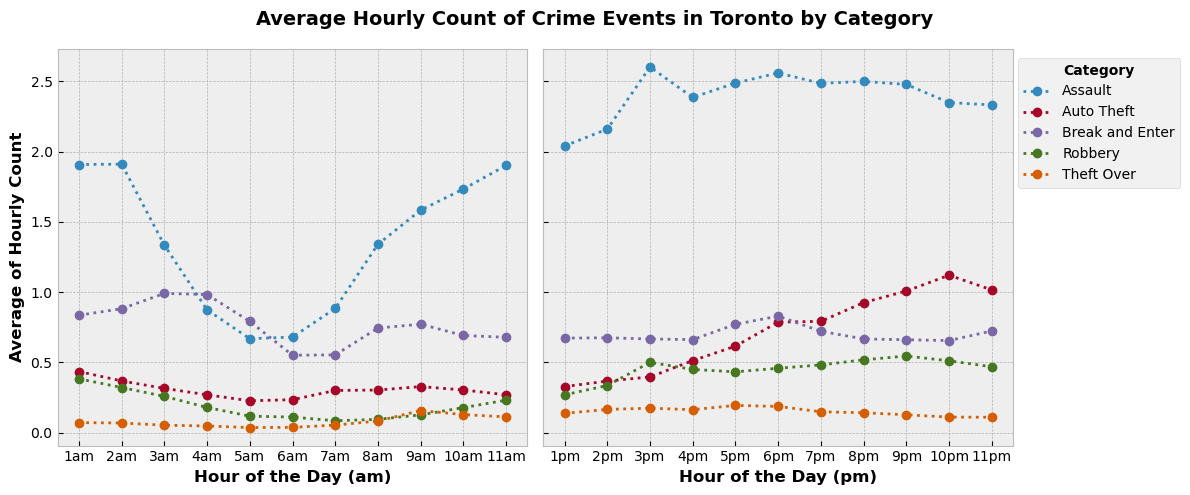

In [64]:
hour_cat_before12_df = hour_cat_df.loc[hour_cat_df['Hour']<12]
hour_cat_after12_df = hour_cat_df.loc[hour_cat_df['Hour'] > 12]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

for ax in [ax1, ax2]:
    if ax is ax1:
        the_df = hour_cat_before12_df
        # hour_labels = [str(n).zfill(2) for n in np.arange(1, 12)]
        ampm = 'am'
        hour_ticks = np.arange(1, 12)
        ax.set_ylabel('Average of Hourly Count', fontdict={'weight': 700})
    else:
        the_df = hour_cat_after12_df
        ampm = 'pm'
        hour_ticks = np.arange(13, 24)
        # hour_labels = [str(n) for n in np.arange(13, 24)]


    for cat in cats:
        this_data = the_df.loc[the_df['Category'] == cat]
        # add this category to the plot
        ax.plot(
            this_data['Hour'],
            this_data['hour_average'],
            'o:',
            label=cat
        )


    ax.set_xlabel('Hour of the Day (' + ampm + ')', fontdict={'weight': 700})
    
    hour_labels = [str(n) + ampm for n in np.arange(1, 12)]

    ax.set_xticks(
        ticks=hour_ticks,
        labels=hour_labels
    )
ax2.legend(
    loc=(1.01, 0.65), 
    # loc='best',
    title='Category', 
    title_fontproperties={'weight': 700}
)
fig.suptitle(
    'Average Hourly Count of Crime Events in Toronto by Category',
    fontweight=700, fontsize=14
)

fig.tight_layout()

plt.show()